# 1. Import Libraries

In [387]:
import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

from sklearn.svm import SVC

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from datetime import datetime

from scipy.optimize import minimize

# 2. Load the Dataset

In [388]:
path = '/content/breast-cancer.csv'
dataset = pd.read_csv(path)
print("Dataset Loaded:\n", dataset.head())

Dataset Loaded:
          id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   ...  radius_worst  texture_worst  perimete

In [389]:
print(dataset.shape)

(569, 32)


In [390]:
print(dataset.isnull().sum())

id                         0
diagnosis                  0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64


In [391]:
print(dataset.dtypes)

id                           int64
diagnosis                   object
radius_mean                float64
texture_mean               float64
perimeter_mean             float64
area_mean                  float64
smoothness_mean            float64
compactness_mean           float64
concavity_mean             float64
concave points_mean        float64
symmetry_mean              float64
fractal_dimension_mean     float64
radius_se                  float64
texture_se                 float64
perimeter_se               float64
area_se                    float64
smoothness_se              float64
compactness_se             float64
concavity_se               float64
concave points_se          float64
symmetry_se                float64
fractal_dimension_se       float64
radius_worst               float64
texture_worst              float64
perimeter_worst            float64
area_worst                 float64
smoothness_worst           float64
compactness_worst          float64
concavity_worst     

# 3. Preprocess the Dataset

In [392]:
dataset.drop(columns=['id'], inplace=True)
print('Column id is droped because it doesn\'t affect the classification.')

Column id is droped because it doesn't affect the classification.


In [393]:
dataset['diagnosis'] = dataset['diagnosis'].map({'B': -1, 'M': 1})

In [394]:
def preprocess_dataset(dataset, target_columns):

    # Encode categorical variables
    le = LabelEncoder()

    for column in dataset.select_dtypes(include=['object']).columns:
        dataset[column] = le.fit_transform(dataset[column])

    # Split dataset
    X = dataset.drop(columns=target_columns, axis=1)  # Features
    y = dataset[target_columns] # Target
    X = X.to_numpy()
    y = y.to_numpy().reshape(-1, 1)

    sc = MinMaxScaler()
    X = sc.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    return X_train, X_test, y_train, y_test

In [395]:
X_train, X_test, y_train, y_test = preprocess_dataset(dataset, target_columns=['diagnosis'])
print("Data Preprocessing Completed.")

Data Preprocessing Completed.


In [396]:
print(dataset.dtypes)

diagnosis                    int64
radius_mean                float64
texture_mean               float64
perimeter_mean             float64
area_mean                  float64
smoothness_mean            float64
compactness_mean           float64
concavity_mean             float64
concave points_mean        float64
symmetry_mean              float64
fractal_dimension_mean     float64
radius_se                  float64
texture_se                 float64
perimeter_se               float64
area_se                    float64
smoothness_se              float64
compactness_se             float64
concavity_se               float64
concave points_se          float64
symmetry_se                float64
fractal_dimension_se       float64
radius_worst               float64
texture_worst              float64
perimeter_worst            float64
area_worst                 float64
smoothness_worst           float64
compactness_worst          float64
concavity_worst            float64
concave points_worst

# 4. Utilities

In [397]:
def visualize_decision_boundary(model, X, y, title):
    X_pca = X
    x_min, x_max = X_pca[:,0].min() - 1, X_pca[:,0].max() + 1
    y_min, y_max = X_pca[:,1].min() - 1, X_pca[:,1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500), np.linspace(y_min, y_max, 500))

    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = model.predict(grid).reshape(xx.shape)

    plt.figure(figsize=(8,6))
    # Фон классов
    plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), Z.max(), 50), cmap='coolwarm', alpha=0.3)
    # Граница решений (уровень 0)
    plt.contour(xx, yy, Z, levels=[0], colors='k', linewidths=2)
    plt.scatter(X_pca[:,0], X_pca[:,1], c=y, edgecolors='k', cmap='coolwarm')
    plt.title(title)
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.show()

# 5. Reference SVM

In [398]:
pca = PCA(n_components=2)  # Reduce to 2 dimensions for visualization
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

## 5.1. Linear SVM

In [399]:
svm_linear_ref = SVC(kernel="linear", C=25)
svm_linear_ref.fit(X_train_pca, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(C=25, kernel='linear')

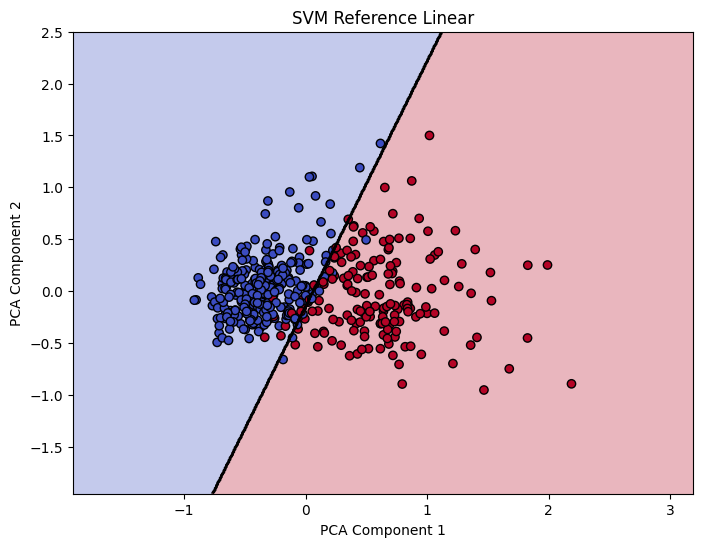

In [400]:
visualize_decision_boundary(svm_linear_ref, X_train_pca, y_train, "SVM Reference Linear")


SVM Reference Linear

Execution Time: 1293 mcs

Accuracy: 0.97

Classification Report:
               precision    recall  f1-score   support

          -1       0.97      0.99      0.98        71
           1       0.98      0.95      0.96        43

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114


Confusion Matrix:



<Axes: >

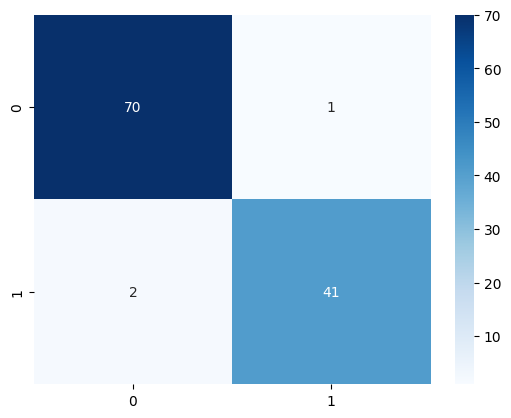

In [401]:
start_time = datetime.now()

y_pred = svm_linear_ref.predict(X_test_pca)

end_time = datetime.now()

# Metrics
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
matrix = confusion_matrix(y_test, y_pred)

print(f"\nSVM Reference Linear")
print(f"\nExecution Time: {(end_time - start_time).microseconds} mcs")
print(f"\nAccuracy: {accuracy:.2f}")
print("\nClassification Report:\n", report)
print("\nConfusion Matrix:\n")
sns.heatmap(matrix, annot=True, cmap="Blues")

## 5.2. RBF SVM

In [402]:
svm_rbf_ref = SVC(kernel="rbf", C=2.0, gamma=2.0)
svm_rbf_ref.fit(X_train_pca, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(C=2.0, gamma=2.0)

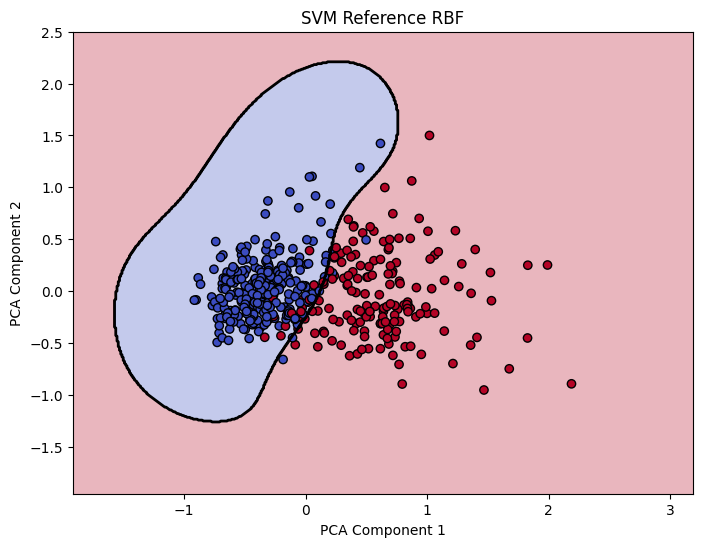

In [403]:
visualize_decision_boundary(svm_rbf_ref, X_train_pca, y_train, "SVM Reference RBF")


SVM Reference RBF

Execution Time: 1751 mcs

Accuracy: 0.96

Classification Report:
               precision    recall  f1-score   support

          -1       0.96      0.99      0.97        71
           1       0.98      0.93      0.95        43

    accuracy                           0.96       114
   macro avg       0.97      0.96      0.96       114
weighted avg       0.97      0.96      0.96       114


Confusion Matrix:



<Axes: >

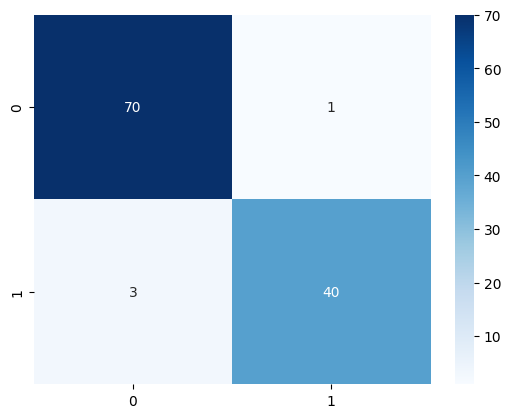

In [404]:
start_time = datetime.now()

y_pred = svm_rbf_ref.predict(X_test_pca)

end_time = datetime.now()

# Metrics
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
matrix = confusion_matrix(y_test, y_pred)

print(f"\nSVM Reference RBF")
print(f"\nExecution Time: {(end_time - start_time).microseconds} mcs")
print(f"\nAccuracy: {accuracy:.2f}")
print("\nClassification Report:\n", report)
print("\nConfusion Matrix:\n")
sns.heatmap(matrix, annot=True, cmap="Blues")

## 5.3. Poly SVM

In [405]:
svm_poly_ref = SVC(kernel="poly", C=25, degree=3)
svm_poly_ref.fit(X_train_pca, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(C=25, kernel='poly')

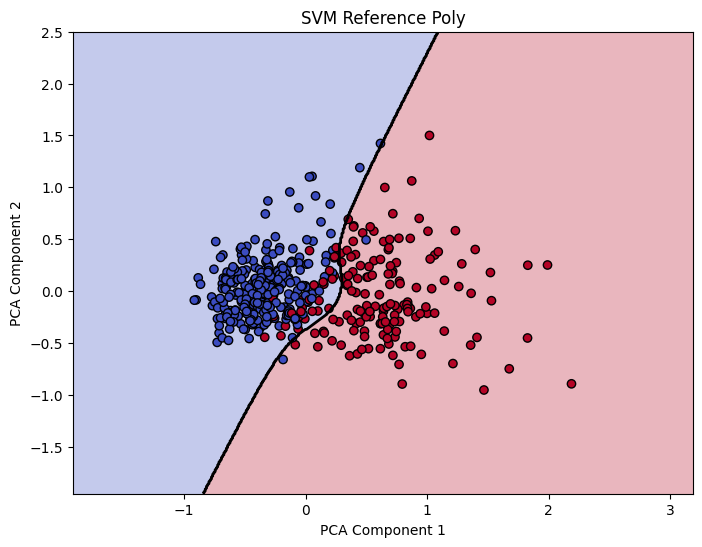

In [406]:
visualize_decision_boundary(svm_poly_ref, X_train_pca, y_train, "SVM Reference Poly")


SVM Reference Poly

Execution Time: 1579 mcs

Accuracy: 0.95

Classification Report:
               precision    recall  f1-score   support

          -1       0.92      1.00      0.96        71
           1       1.00      0.86      0.93        43

    accuracy                           0.95       114
   macro avg       0.96      0.93      0.94       114
weighted avg       0.95      0.95      0.95       114


Confusion Matrix:



<Axes: >

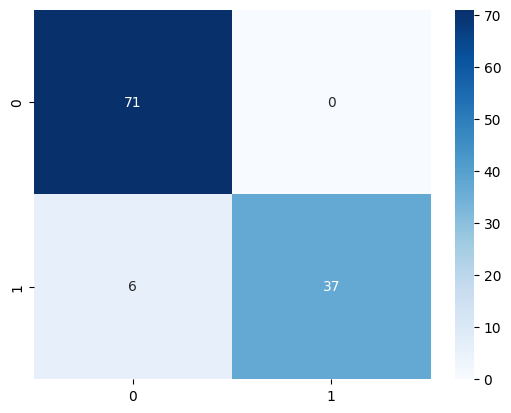

In [407]:
start_time = datetime.now()

y_pred = svm_poly_ref.predict(X_test_pca)

end_time = datetime.now()

# Metrics
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
matrix = confusion_matrix(y_test, y_pred)

print(f"\nSVM Reference Poly")
print(f"\nExecution Time: {(end_time - start_time).microseconds} mcs")
print(f"\nAccuracy: {accuracy:.2f}")
print("\nClassification Report:\n", report)
print("\nConfusion Matrix:\n")
sns.heatmap(matrix, annot=True, cmap="Blues")

# 6. Custom SVM

In [408]:
pca = PCA(n_components=2)  # Reduce to 2 dimensions for visualization
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [409]:
class CustomSVM:
    def __init__(self, kernel="linear", C=1.0, gamma=0.8, degree=3):
        self.kernel = kernel
        self.C = C
        self.gamma = gamma
        self.degree = degree
        self.support_vectors = None
        self.support_multipliers = None
        self.support_labels = None
        self.bias = 0

    def apply_kernel(self, X1, X2):
        if self.kernel == "linear":
            return np.dot(X1, X2.T)
        elif self.kernel == "rbf":
            sq_dists = np.sum(X1**2, axis=1).reshape(-1, 1) + np.sum(X2**2, axis=1) - 2 * np.dot(X1, X2.T)
            return np.exp(-self.gamma * sq_dists)
        elif self.kernel == "poly":
            return (np.dot(X1, X2.T) + 1) ** self.degree
        else:
            raise ValueError(f"Unknown kernel: {self.kernel}")

    def fit(self, X, y):
        y = np.asarray(y).flatten()  # Ensure y is 1D
        N = len(y)

        # Compute the Gram matrix
        K = self.apply_kernel(X, X)
        G = np.outer(y, y) * K

        # Define the dual Lagrangian
        def Lagrangian(l):
            return np.sum(l) - 0.5 * np.dot(l, np.dot(G, l))

        # Define constraints
        constraints = [
            {"type": "eq", "fun": lambda l: np.dot(l, y)},  # Sum of lambda_i * y_i = 0
        ]
        bounds = [(0, self.C) for _ in range(N)]  # 0 <= lambda_i <= C

        # Optimize
        result = minimize(
            fun=lambda l: -Lagrangian(l),  # Minimize negative Lagrangian
            x0=np.zeros(N),               # Initial guess
            bounds=bounds,
            constraints=constraints,
            method="SLSQP"
        )

        if not result.success:
            raise ValueError(f"Optimization failed: {result.message}")

        # Extract Lagrange multipliers
        lambdas = result.x

        # Support vectors
        idx = lambdas > 1e-5  # Non-zero lambdas are support vectors
        self.support_vectors = X[idx]
        self.support_multipliers = lambdas[idx]
        self.support_labels = y[idx]

        # Compute bias (b)
        self.bias = np.mean(
            self.support_labels - np.sum(self.support_multipliers * self.support_labels[:, None] * K[idx][:, idx], axis=1)
        )

    def predict(self, X):
        K = self.apply_kernel(X, self.support_vectors)
        decision = np.dot(K, self.support_multipliers * self.support_labels) + self.bias
        return np.sign(decision)


## 6.1. Linear SVM

In [410]:
svm_linear_cus = CustomSVM(kernel="linear", C=25)
svm_linear_cus.fit(X_train_pca, y_train)

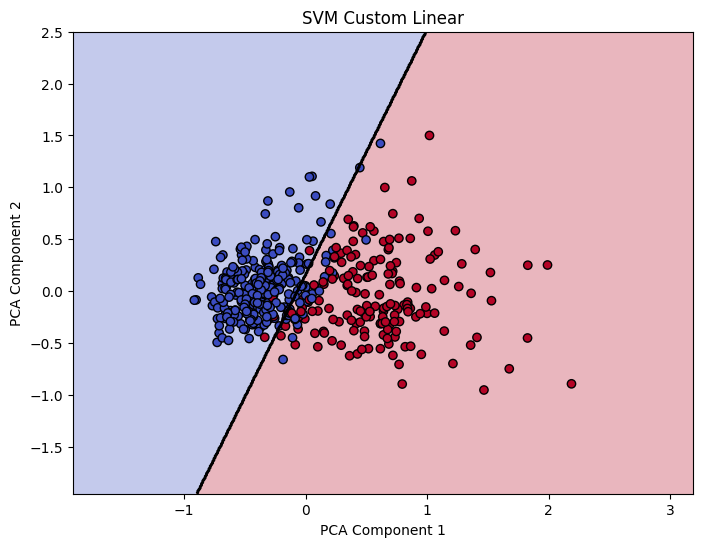

In [411]:
visualize_decision_boundary(svm_linear_cus, X_train_pca, y_train, "SVM Custom Linear")


SVM Custom Linear

Execution Time: 261 mcs

Accuracy: 0.96

Classification Report:
               precision    recall  f1-score   support

          -1       1.00      0.94      0.97        71
           1       0.91      1.00      0.96        43

    accuracy                           0.96       114
   macro avg       0.96      0.97      0.96       114
weighted avg       0.97      0.96      0.97       114


Confusion Matrix:



<Axes: >

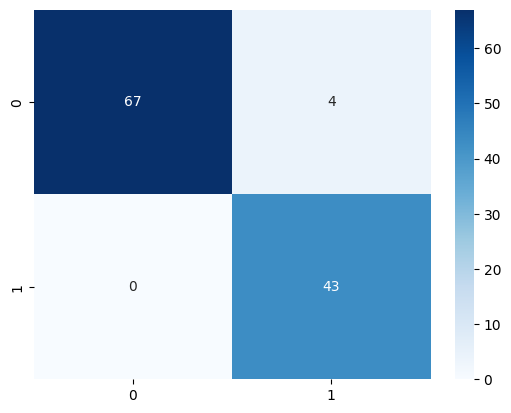

In [412]:
start_time = datetime.now()

y_pred = svm_linear_cus.predict(X_test_pca)

end_time = datetime.now()

# Metrics
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
matrix = confusion_matrix(y_test, y_pred)

print(f"\nSVM Custom Linear")
print(f"\nExecution Time: {(end_time - start_time).microseconds} mcs")
print(f"\nAccuracy: {accuracy:.2f}")
print("\nClassification Report:\n", report)
print("\nConfusion Matrix:\n")
sns.heatmap(matrix, annot=True, cmap="Blues")

## 6.2. RBF SVM

In [413]:
svm_rbf_cus = CustomSVM(kernel="rbf", C=2.0, gamma=2.0)
svm_rbf_cus.fit(X_train_pca, y_train)

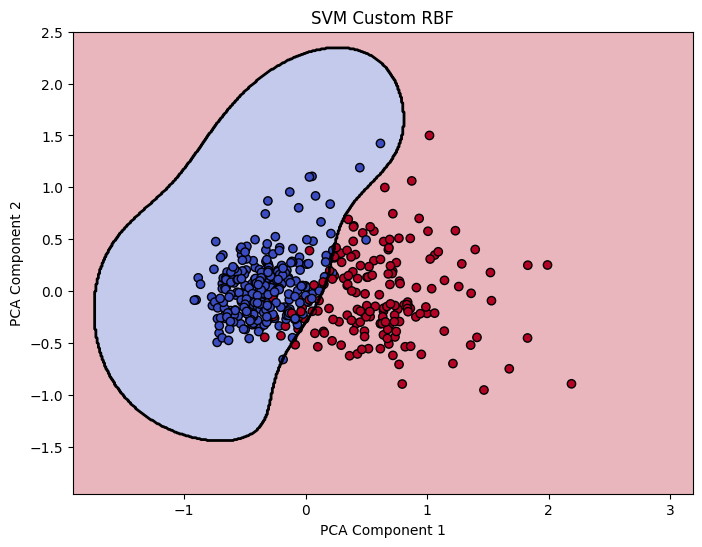

In [414]:
visualize_decision_boundary(svm_rbf_cus, X_train_pca, y_train, "SVM Custom RBF")


SVM Custom RBF

Execution Time: 673 mcs

Accuracy: 0.96

Classification Report:
               precision    recall  f1-score   support

          -1       0.95      0.99      0.97        71
           1       0.97      0.91      0.94        43

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114


Confusion Matrix:



<Axes: >

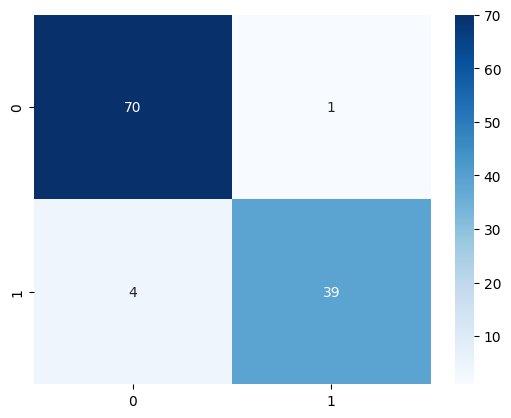

In [415]:
start_time = datetime.now()

y_pred = svm_rbf_cus.predict(X_test_pca)

end_time = datetime.now()

# Metrics
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
matrix = confusion_matrix(y_test, y_pred)

print(f"\nSVM Custom RBF")
print(f"\nExecution Time: {(end_time - start_time).microseconds} mcs")
print(f"\nAccuracy: {accuracy:.2f}")
print("\nClassification Report:\n", report)
print("\nConfusion Matrix:\n")
sns.heatmap(matrix, annot=True, cmap="Blues")

## 6.3. Poly SVM

In [416]:
svm_poly_cus = CustomSVM(kernel="poly", C=2, degree=3)
svm_poly_cus.fit(X_train_pca, y_train)

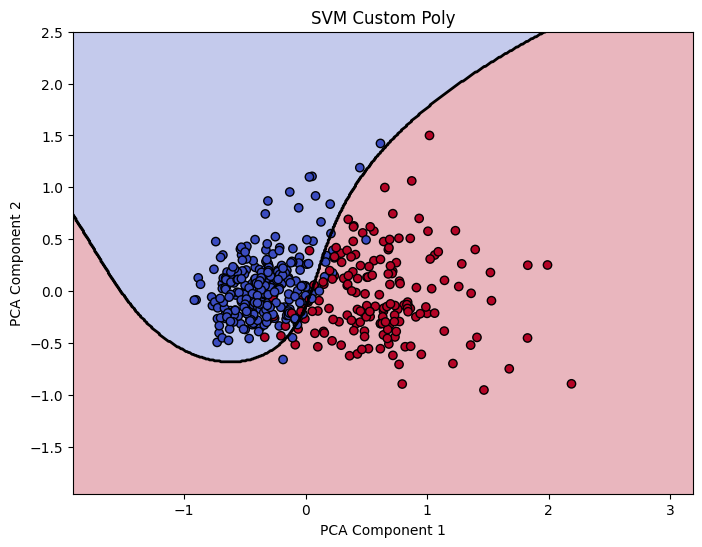

In [417]:
visualize_decision_boundary(svm_poly_cus, X_train_pca, y_train, "SVM Custom Poly")


SVM Custom Poly

Execution Time: 738 mcs

Accuracy: 0.98

Classification Report:
               precision    recall  f1-score   support

          -1       0.99      0.99      0.99        71
           1       0.98      0.98      0.98        43

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114


Confusion Matrix:



<Axes: >

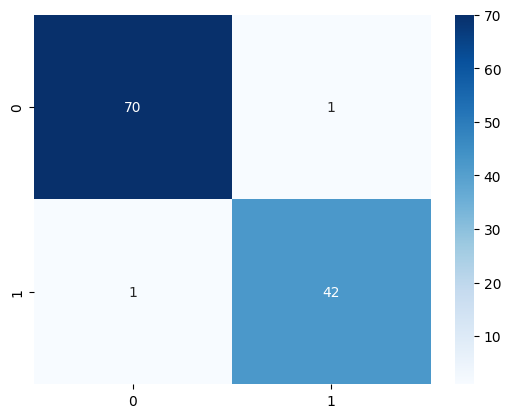

In [418]:
start_time = datetime.now()

y_pred = svm_poly_cus.predict(X_test_pca)

end_time = datetime.now()

# Metrics
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
matrix = confusion_matrix(y_test, y_pred)

print(f"\nSVM Custom Poly")
print(f"\nExecution Time: {(end_time - start_time).microseconds} mcs")
print(f"\nAccuracy: {accuracy:.2f}")
print("\nClassification Report:\n", report)
print("\nConfusion Matrix:\n")
sns.heatmap(matrix, annot=True, cmap="Blues")